In [4]:
# ------------------------------
# 1. Imports
# ------------------------------
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ------------------------------
# 2. Paths
# ------------------------------
BASE_DIR = os.path.dirname(os.getcwd())  # project root
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")

# ------------------------------
# 3. Load cleaned datasets
# ------------------------------
files = {
    "final": "final_dataset_clean.csv",
    "stations": "ev-charging-stations-india_clean.csv",
    "makers": "ev_maker_by_place_clean.csv",
    "ev_cat": "ev-cat_01-24_clean.csv",
    "operational": "operationalpc_clean.csv",
    "vehicle_class": "vehicle_cladd-all_clean.csv"
}

datasets = {}
for name, fname in files.items():
    path = os.path.join(PROCESSED_DIR, fname)
    if os.path.exists(path):
        df = pd.read_csv(path)
        datasets[name] = df
        print(f"✅ Loaded {name}: {df.shape}")
    else:
        print(f"❌ Missing: {fname}")

# Unpack for convenience
df_final = datasets.get("final")
df_stations = datasets.get("stations")
df_makers = datasets.get("makers")
df_evcat = datasets.get("ev_cat")
df_operational = datasets.get("operational")
df_vehicle = datasets.get("vehicle_class")

# ------------------------------
# 4. Quick inspection
# ------------------------------
print("\nFinal dataset preview:")
print(df_final.head())

print("\nStations dataset preview:")
print(df_stations.head())


✅ Loaded final: (32, 13)
✅ Loaded stations: (1342, 7)
✅ Loaded makers: (61, 3)
❌ Missing: ev-cat_01-24_clean.csv
✅ Loaded operational: (34, 2)
❌ Missing: vehicle_cladd-all_clean.csv

Final dataset preview:
   unnamed:_0                  state_name  two_wheeler  three_wheeler  \
0           0  Andaman and Nicobar Island            1           30.0   
1           1           Arunachal Pradesh           14            0.0   
2           2                       Assam          721        47041.0   
3           3                       Bihar         5003        59079.0   
4           4                  Chandigarh          298         1410.0   

   four_wheeler  goods_vehicles  public_service_vehicle  \
0            81             0.0                    40.0   
1             5             0.0                     0.0   
2           161             7.0                    15.0   
3           114            11.0                    26.0   
4           182             0.0                    40.0   



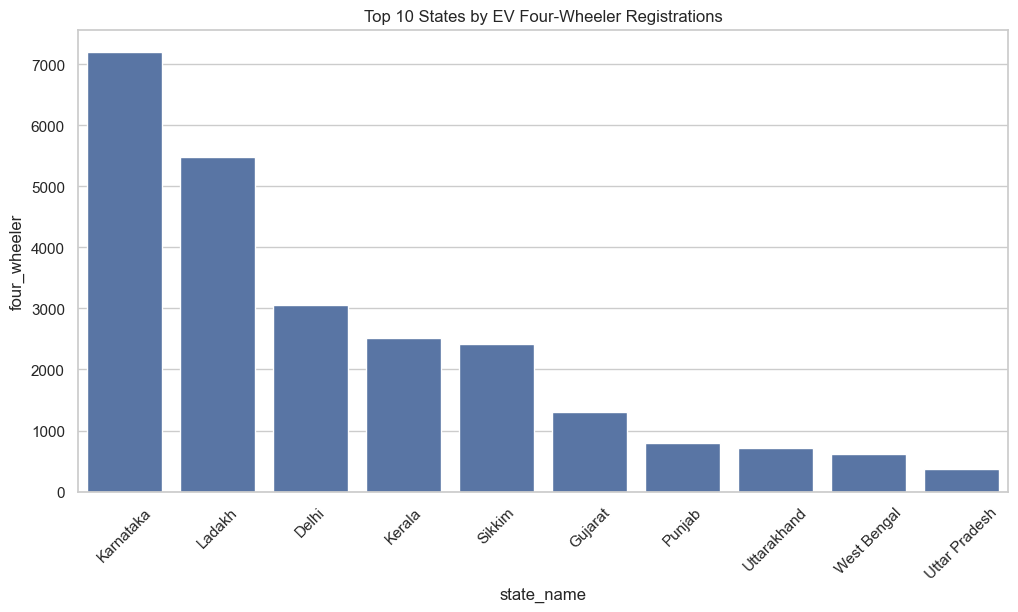

In [5]:
plt.figure(figsize=(12,6))
sns.barplot(x="state_name", y="four_wheeler", data=df_final.sort_values("four_wheeler", ascending=False).head(10))
plt.xticks(rotation=45)
plt.title("Top 10 States by EV Four-Wheeler Registrations")
plt.show()


In [7]:
print("Operational dataset columns:", df_operational.columns.tolist())
print(df_operational.head())



Operational dataset columns: ['state', 'no._of_operational_pcs']
               state  no._of_operational_pcs
0  Andaman & Nicobar                       3
1     Andhra Pradesh                     327
2  Arunachal Pradesh                       9
3              Assam                      86
4              Bihar                     124


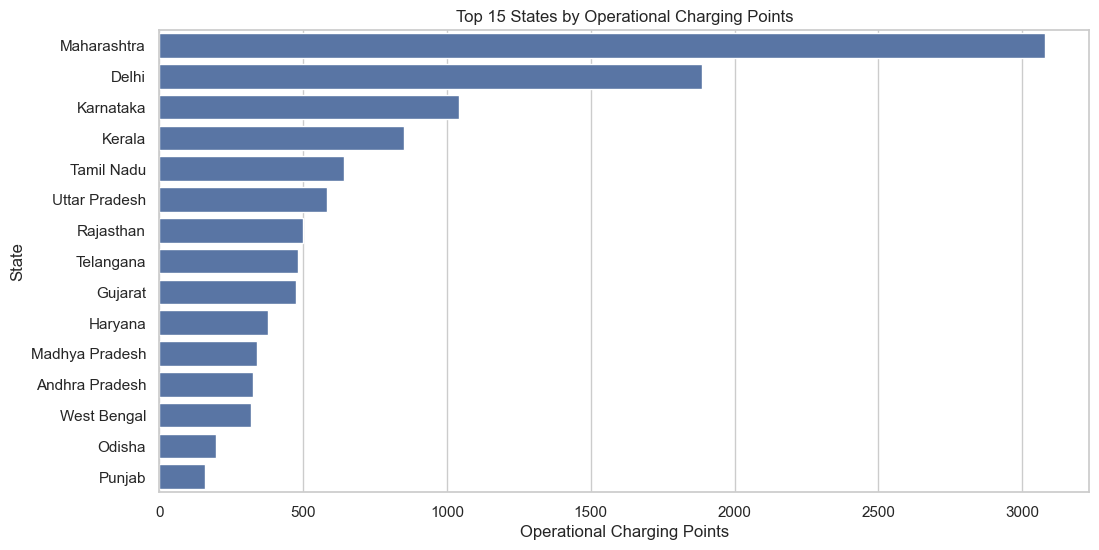

In [8]:
plt.figure(figsize=(12,6))
sns.barplot(
    y="state", 
    x="no._of_operational_pcs",
    data=df_operational.sort_values("no._of_operational_pcs", ascending=False).head(15)
)
plt.title("Top 15 States by Operational Charging Points")
plt.xlabel("Operational Charging Points")
plt.ylabel("State")
plt.show()


In [9]:
# ------------------------------
# KPI 1: EV-to-Station Ratio
# ------------------------------

# Take 4W, 2W, 3W etc. and sum them
df_final["total_evs"] = (
    df_final["two_wheeler"] + 
    df_final["three_wheeler"] + 
    df_final["four_wheeler"] + 
    df_final["goods_vehicles"] + 
    df_final["public_service_vehicle"]
)

# Merge with operational charging points dataset
kpi_df = df_final.merge(
    df_operational,
    left_on="state_name",
    right_on="state",
    how="inner"
)

# Calculate EV per charging point
kpi_df["evs_per_station"] = (
    kpi_df["total_evs"] / kpi_df["no._of_operational_pcs"]
).round(2)

print("Sample KPI Table:")
print(kpi_df[["state_name", "total_evs", "no._of_operational_pcs", "evs_per_station"]].head())


Sample KPI Table:
          state_name  total_evs  no._of_operational_pcs  evs_per_station
0  Arunachal Pradesh       19.0                       9             2.11
1              Assam    47945.0                      86           557.50
2              Bihar    64233.0                     124           518.01
3         Chandigarh     1930.0                      12           160.83
4       Chhattisgarh    12960.0                     149            86.98


#Year-on-Year Growth (from EV Categories dataset)

In [12]:
# ------------------------------
# KPI 2: EV Growth Rate (YoY)
# ------------------------------
if df_evcat is not None:
    yearly = df_evcat.groupby("year")["total"].sum().reset_index()
    yearly["growth_pct"] = yearly["total"].pct_change().fillna(0) * 100

    print("EV Yearly Growth:")
    print(yearly)

    # Quick plot
    plt.figure(figsize=(10,5))
    plt.plot(yearly["year"], yearly["total"], marker="o", label="Total EVs")
    plt.bar(yearly["year"], yearly["growth_pct"], alpha=0.3, label="Growth %")
    plt.legend()
    plt.title("EV Growth Trend (Total & % Growth)")
    plt.show()


#: Charging Infrastructure Share by State


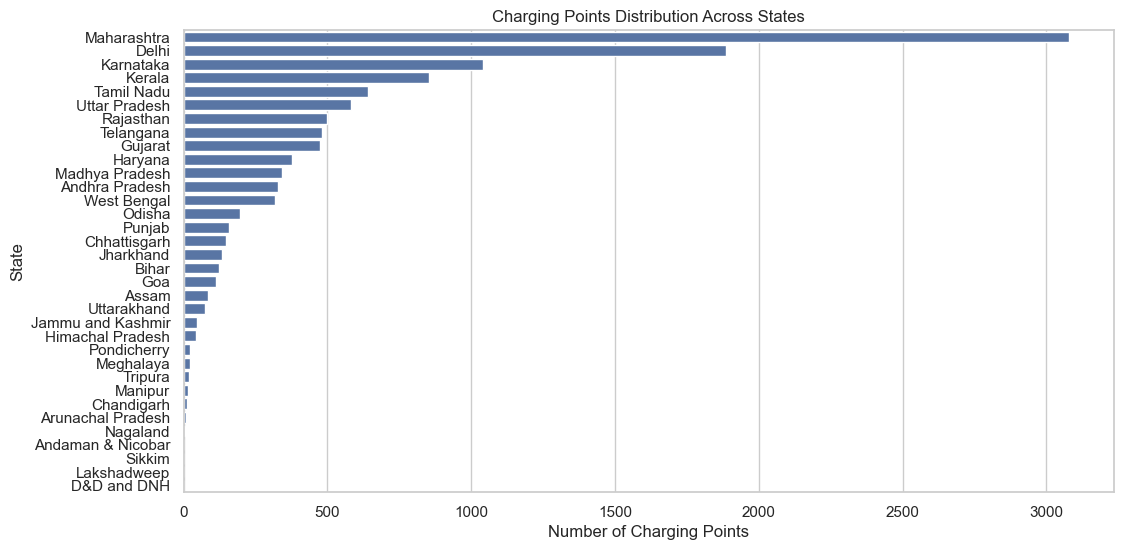

In [11]:
plt.figure(figsize=(12,6))
sns.barplot(
    x="no._of_operational_pcs",
    y="state",
    data=df_operational.sort_values("no._of_operational_pcs", ascending=False)
)
plt.title("Charging Points Distribution Across States")
plt.xlabel("Number of Charging Points")
plt.ylabel("State")
plt.show()
